In [ ]:

import numpy as np

from benchmarl.environments.common import Task, TaskClass

from benchmarl.utils import DEVICE_TYPING

from gymnasium import spaces
from pettingzoo import ParallelEnv
import numpy as np
import random
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
from torchrl.data import CompositeSpec
# from torchrl.envs import EnvBase, PettingZooWrapper
from torchrl.envs import PettingZooWrapper
import torch


In [2]:
class MyCustomEnv2(ParallelEnv):
    """Custom GridWorld environment following PettingZoo Parallel interface with multiple moving agents"""
    metadata = {'render.modes': ['human'], "name": "gridworld_parallel_v0"}

    def __init__(self, size=(10, 10), target=(0, 0), obstacles=None, num_moving_agents=50):
        super().__init__()
        self.size = size
        self.target = target
        obstacles_test = [(x, y) for x in range(1, 9) for y in range(1, 9)]
        self.obstacles = obstacles_test if obstacles_test else []
        self.num_moving_agents = num_moving_agents

        # Define agents
        self.agents = [f"movement_agent_{i}" for i in range(num_moving_agents)]
        self.possible_agents = self.agents[:]

        # Action spaces: discrete for movement agents
        self.action_spaces = {
            agent: spaces.Discrete(5) for agent in self.agents
        }

        # Observation spaces: position + flattened mean field
        grid_area = size[0] * size[1]
        movement_obs_size = 2 + grid_area
        self.observation_spaces = {
            agent: spaces.Box(low=0, high=1, shape=(movement_obs_size,), dtype=np.float32)
            for agent in self.agents
        }

        # Movement directions: Left, Right, Stay, Up, Down
        self.actions = [(-1, 0), (1, 0), (0, 0), (0, 1), (0, -1)]

        # State variables
        self.positions = []
        self.mean_field = np.zeros(self.size, dtype=np.float32)
        self.steps = 0
        self.max_steps = 100
        self.congestion_coefficient = 1

    def reset(self, seed=42, options=None):
        random.seed(seed)
        self.agents = self.possible_agents[:]
        self.positions = []
        for _ in range(self.num_moving_agents):
            x = int(9 )
            y = int(9 )
            self.positions.append((x, y))
        self.steps = 0
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self._update_mean_field()
        return self._get_obs(), self._get_info()

    def _update_mean_field(self):
        mean_field = np.zeros(self.size, dtype=np.float32)
        for x, y in self.positions:
            mean_field[x, y] += 1
        self.mean_field = mean_field / max(self.num_moving_agents, 1)

    def is_valid_position(self, pos):
        x, y = pos
        return (0 <= x < self.size[0] and
                0 <= y < self.size[1] and
                pos not in self.obstacles)

    def step(self, actions):
        """Execute a step for all agents in parallel"""
        rewards = {}
        new_positions = self.positions.copy()

        for agent, action in actions.items():
            agent_idx = int(agent.split("_")[2])
            pos = self.positions[agent_idx]

            if pos == self.target:
                rewards[agent] = 0
                continue

            dx, dy = self.actions[action]
            new_pos = (pos[0] + dx, pos[1] + dy)

            if self.is_valid_position(new_pos):
                new_positions[agent_idx] = new_pos

            # Reward: bonus for reaching target, penalty for time + congestion
            time_cost = 0.5
            x, y = new_positions[agent_idx]
            congestion_cost = self.mean_field[x, y] if self.is_valid_position(new_pos) else 10
            target_bonus = 15 if new_positions[agent_idx] == self.target else 0

            rewards[agent] = target_bonus - (time_cost + self.congestion_coefficient * congestion_cost)

        self.positions = new_positions
        self._update_mean_field()
        self.steps += 1

        # Check termination
        terminated = all(pos == self.target for pos in self.positions)
        truncated = self.steps >= self.max_steps
        self.terminations = {agent: terminated for agent in self.agents}
        self.truncations = {agent: truncated for agent in self.agents}

        self.rewards = rewards
        return self._get_obs(), rewards, self.terminations, self.truncations, self._get_info()

    def _get_obs(self):
        obs = {}
        flat_mean_field = self.mean_field.copy().flatten()
        for agent_idx, agent in enumerate(self.agents):
            position = np.array(self.positions[agent_idx], dtype=np.float32)
            position[0] /= self.size[0]
            position[1] /= self.size[1]
            
            # -----------------------------------------------------------------
            # THE FIX: Force a deep copy of the final observation array
            # -----------------------------------------------------------------
            obs[agent] = np.concatenate([position, flat_mean_field])
            
        return obs

    def _get_info(self):
        return {agent: {} for agent in self.agents}

    def render(self, mode="human"):
        grid_size = self.size[0]

        if not hasattr(self, "fig") or self.fig is None:
            plt.ion()
            self.fig, self.ax = plt.subplots(figsize=(6, 6))
            self.colorbar = None

        self.ax.clear()
        density = self.mean_field.copy()
        masked_density = np.ma.array(density, mask=False)
        for ox, oy in self.obstacles:
            masked_density[ox, oy] = np.nan

        cmap = plt.cm.Reds
        cmap.set_bad(color="black")

        im = self.ax.imshow(masked_density, origin="upper", cmap=cmap, interpolation="nearest")

        # Mark target
        self.ax.scatter(
            self.target[1],
            self.target[0],
            marker="s",
            c="lime",
            edgecolor="black",
            s=200,
            label="Target"
        )

        self.ax.set_xticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_yticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True, which="both", color="black", linewidth=0.5)
        self.ax.set_xlim(-0.5, grid_size - 0.5)
        self.ax.set_ylim(-0.5, grid_size - 0.5)

        if self.colorbar is None:
            self.colorbar = self.fig.colorbar(im, ax=self.ax, fraction=0.046, pad=0.04, label="Agent density")
        else:
            self.colorbar.update_normal(im)

        plt.pause(0.01)

    def close(self):
        if hasattr(self, "fig") and self.fig is not None:
            plt.close(self.fig)
            self.fig = None
            self.ax = None
            self.colorbar = None

In [3]:
class EnvNxN(ParallelEnv):
    """Custom GridWorld environment following PettingZoo Parallel interface with multiple moving agents"""
    metadata = {'render.modes': ['human'], "name": "gridworld_parallel_v0"}

    def __init__(self, size=(3, 3), target=(0, 0), obstacles="middle", num_moving_agents=2):
        super().__init__()
        self.size = size
        self.target = target
        obstacles_test = [(x,y) for x in range(1, size[0]-1) for y in range(1, size[1]-1)]  # n=10 -> (1,1) to (9,9)
        self.obstacles = obstacles_test if obstacles == "middle" else []
        self.num_moving_agents = num_moving_agents

        # Define agents
        self.agents = [f"movement_agent_{i}" for i in range(num_moving_agents)]
        self.possible_agents = self.agents[:]

        # Action spaces: discrete for movement agents
        self.action_spaces = {
            agent: spaces.Discrete(5) for agent in self.agents
        }

        # Observation spaces: position + flattened mean field
        grid_area = size[0] * size[1]
        movement_obs_size = 2 + grid_area
        self.observation_spaces = {
            agent: spaces.Box(low=0, high=1, shape=(movement_obs_size,), dtype=np.float32)
            for agent in self.agents
        }

        # Movement directions: Left, Right, Stay, Up, Down
        self.actions = [(-1, 0), (1, 0), (0, 0), (0, 1), (0, -1)]

        # State variables
        self.positions = []
        self.mean_field = np.zeros(self.size, dtype=np.float32)
        self.steps = 0
        self.max_steps = size[0] * 5
        self.congestion_coefficient = 1

    def reset(self, seed=42, options=None):
        random.seed(seed)
        self.agents = self.possible_agents[:]
        self.positions = []
        for _ in range(self.num_moving_agents):
            x = int(self.size[0]-1)  # n=10 -> 9
            y = int(self.size[1]-1)  # n=10 -> 9
            self.positions.append((x, y))
        self.steps = 0
        self.rewards = {agent: 0 for agent in self.agents}
        self.terminations = {agent: False for agent in self.agents}
        self.truncations = {agent: False for agent in self.agents}
        self.infos = {agent: {} for agent in self.agents}
        self._update_mean_field()
        return self._get_obs(), self._get_info()

    def _update_mean_field(self):
        mean_field = np.zeros(self.size, dtype=np.float32)
        for x, y in self.positions:
            mean_field[x, y] += 1
        self.mean_field = mean_field / max(self.num_moving_agents, 1)

    def is_valid_position(self, pos):
        x, y = pos
        return (0 <= x < self.size[0] and
                0 <= y < self.size[1] and
                pos not in self.obstacles)

    def step(self, actions):
        """Execute a step for all agents in parallel"""
        rewards = {}
        new_positions = self.positions.copy()

        for agent, action in actions.items():
            agent_idx = int(agent.split("_")[2])
            pos = self.positions[agent_idx]

            if pos == self.target:
                rewards[agent] = 0
                continue

            dx, dy = self.actions[action]
            new_pos = (pos[0] + dx, pos[1] + dy)

            if self.is_valid_position(new_pos):
                new_positions[agent_idx] = new_pos

            # Reward: bonus for reaching target, penalty for time + congestion
            time_cost = 0.5
            x, y = new_positions[agent_idx]
            congestion_cost = self.mean_field[x, y] if self.is_valid_position(new_pos) else self.size[0]  # n=10 -> 10, n=3 -> 3
            target_bonus = self.size[0]*1.5  # if new_positions[agent_idx] == self.target else 0  # n=10 -> 15, n=3 -> 4.5

            rewards[agent] = target_bonus - (time_cost + self.congestion_coefficient * congestion_cost)

        self.positions = new_positions
        self._update_mean_field()
        self.steps += 1

        # Check termination
        terminated = all(pos == self.target for pos in self.positions)
        truncated = self.steps >= self.max_steps
        self.terminations = {agent: terminated for agent in self.agents}
        self.truncations = {agent: truncated for agent in self.agents}

        self.rewards = rewards
        return self._get_obs(), rewards, self.terminations, self.truncations, self._get_info()

    def _get_obs(self):
        obs = {}
        flat_mean_field = self.mean_field.copy().flatten()
        for agent_idx, agent in enumerate(self.agents):
            position = np.array(self.positions[agent_idx], dtype=np.float32)
            position[0] /= self.size[0]
            position[1] /= self.size[1]
            # -----------------------------------------------------------------
            # THE FIX: Force a deep copy of the final observation array
            # -----------------------------------------------------------------
            obs[agent] = np.concatenate([position, flat_mean_field])
            
        return obs

    def _get_info(self):
        return {agent: {} for agent in self.agents}

    def render(self, mode="human"):
        grid_size = self.size[0]

        if not hasattr(self, "fig") or self.fig is None:
            plt.ion()
            self.fig, self.ax = plt.subplots(figsize=(6, 6))
            self.colorbar = None

        self.ax.clear()
        density = self.mean_field.copy()
        masked_density = np.ma.array(density, mask=False)
        for ox, oy in self.obstacles:
            masked_density[ox, oy] = np.nan

        cmap = plt.cm.Reds
        cmap.set_bad(color="black")

        im = self.ax.imshow(masked_density, origin="upper", cmap=cmap, interpolation="nearest", vmin=0, vmax=1)

        # Add coordinate text to each grid cell
        for x in range(grid_size):
            for y in range(grid_size):
                if (x,y) not in self.obstacles:
                    self.ax.text(y, x, f"({x},{y})", ha='center', va='center', 
                               fontsize=8, color='black', weight='bold', alpha=0.5)

        # Mark target
        self.ax.scatter(
            self.target[1],
            self.target[0],
            marker="s",
            c="lime",
            edgecolor="black",
            s=200,
            label="Target"
        )

        self.ax.set_xticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_yticks(np.arange(-0.5, grid_size, 1))
        self.ax.set_xticklabels([])
        self.ax.set_yticklabels([])
        self.ax.grid(True, which="both", color="black", linewidth=0.5)
        self.ax.set_xlim(-0.5, grid_size - 0.5)
        self.ax.set_ylim(-0.5, grid_size - 0.5)

        if self.colorbar is None:
            self.colorbar = self.fig.colorbar(im, ax=self.ax, fraction=0.046, pad=0.04, label="Agent density")
        else:
            self.colorbar.update_normal(im)

        plt.pause(0.01)

    def close(self):
        if hasattr(self, "fig") and self.fig is not None:
            plt.close(self.fig)
            self.fig = None
            self.ax = None
            self.colorbar = None

Initial state:
Agent positions: [(9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9), (9, 9)]
Mean field shape: (10, 10)
Observation keys: ['movement_agent_0', 'movement_agent_1', 'movement_agent_2', 'movement_agent_3', 'movement_agent_4', 'movement_agent_5', 'movement_agent_6', 'movement_agent_7', 'movement_agent_8', 'movement_agent_9', 'movement_agent_10', 'movement_agent_11', 'movement_agent_12', 'movement_agent_13', 'movement_agent_14', 'movement_agent_15', 'movement_agent_16', 'movement_agent_17', 'movement_agent_18', 'movement_agent_19', 'movement_agent_20', 'movement_agent_21', 'movement_agent_22', 'movement_agent_23', 'movement_agent_24', 'movem

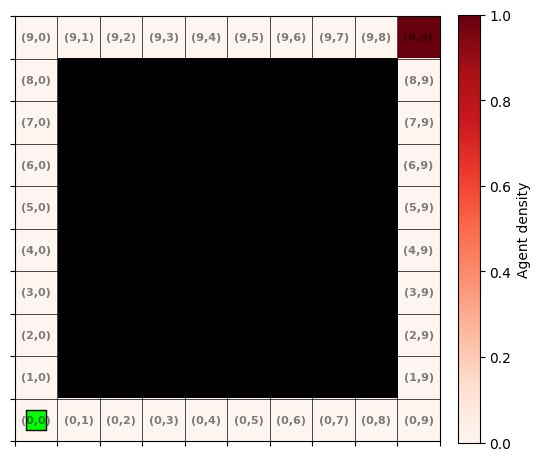


Step 1:
Actions: {'movement_agent_0': np.int64(0), 'movement_agent_1': np.int64(3), 'movement_agent_2': np.int64(1), 'movement_agent_3': np.int64(3), 'movement_agent_4': np.int64(0), 'movement_agent_5': np.int64(2), 'movement_agent_6': np.int64(2), 'movement_agent_7': np.int64(2), 'movement_agent_8': np.int64(2), 'movement_agent_9': np.int64(3), 'movement_agent_10': np.int64(3), 'movement_agent_11': np.int64(0), 'movement_agent_12': np.int64(4), 'movement_agent_13': np.int64(1), 'movement_agent_14': np.int64(3), 'movement_agent_15': np.int64(2), 'movement_agent_16': np.int64(2), 'movement_agent_17': np.int64(3), 'movement_agent_18': np.int64(2), 'movement_agent_19': np.int64(3), 'movement_agent_20': np.int64(2), 'movement_agent_21': np.int64(4), 'movement_agent_22': np.int64(3), 'movement_agent_23': np.int64(4), 'movement_agent_24': np.int64(4), 'movement_agent_25': np.int64(4), 'movement_agent_26': np.int64(0), 'movement_agent_27': np.int64(3), 'movement_agent_28': np.int64(1), 'move

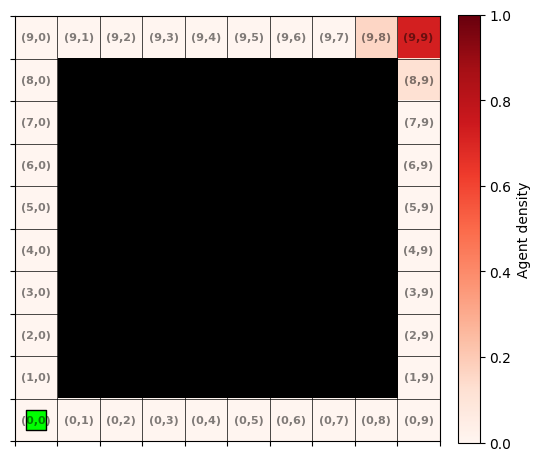


Step 2:
Actions: {'movement_agent_0': np.int64(3), 'movement_agent_1': np.int64(1), 'movement_agent_2': np.int64(2), 'movement_agent_3': np.int64(4), 'movement_agent_4': np.int64(0), 'movement_agent_5': np.int64(0), 'movement_agent_6': np.int64(2), 'movement_agent_7': np.int64(2), 'movement_agent_8': np.int64(1), 'movement_agent_9': np.int64(0), 'movement_agent_10': np.int64(3), 'movement_agent_11': np.int64(1), 'movement_agent_12': np.int64(0), 'movement_agent_13': np.int64(0), 'movement_agent_14': np.int64(2), 'movement_agent_15': np.int64(0), 'movement_agent_16': np.int64(2), 'movement_agent_17': np.int64(0), 'movement_agent_18': np.int64(1), 'movement_agent_19': np.int64(1), 'movement_agent_20': np.int64(4), 'movement_agent_21': np.int64(1), 'movement_agent_22': np.int64(0), 'movement_agent_23': np.int64(0), 'movement_agent_24': np.int64(1), 'movement_agent_25': np.int64(4), 'movement_agent_26': np.int64(2), 'movement_agent_27': np.int64(4), 'movement_agent_28': np.int64(0), 'move

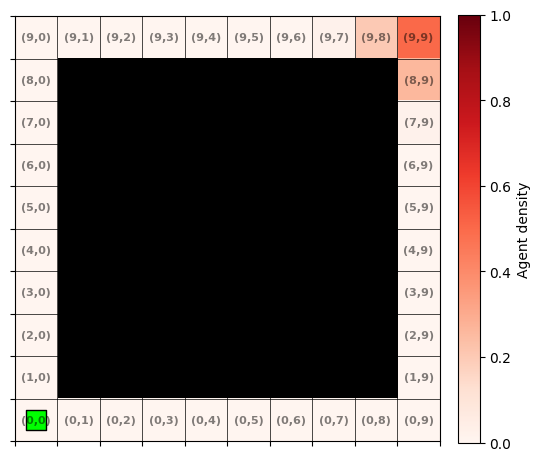


Step 3:
Actions: {'movement_agent_0': np.int64(1), 'movement_agent_1': np.int64(4), 'movement_agent_2': np.int64(4), 'movement_agent_3': np.int64(4), 'movement_agent_4': np.int64(4), 'movement_agent_5': np.int64(4), 'movement_agent_6': np.int64(2), 'movement_agent_7': np.int64(1), 'movement_agent_8': np.int64(3), 'movement_agent_9': np.int64(4), 'movement_agent_10': np.int64(3), 'movement_agent_11': np.int64(0), 'movement_agent_12': np.int64(2), 'movement_agent_13': np.int64(0), 'movement_agent_14': np.int64(1), 'movement_agent_15': np.int64(3), 'movement_agent_16': np.int64(0), 'movement_agent_17': np.int64(2), 'movement_agent_18': np.int64(1), 'movement_agent_19': np.int64(2), 'movement_agent_20': np.int64(4), 'movement_agent_21': np.int64(3), 'movement_agent_22': np.int64(2), 'movement_agent_23': np.int64(0), 'movement_agent_24': np.int64(4), 'movement_agent_25': np.int64(0), 'movement_agent_26': np.int64(1), 'movement_agent_27': np.int64(0), 'movement_agent_28': np.int64(1), 'move

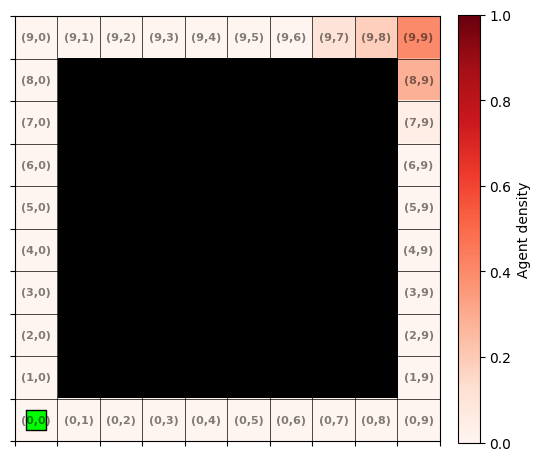

In [4]:
# Test the environment with random actions
env = EnvNxN(size=(10, 10), num_moving_agents = 50, obstacles = "middle")  # Start with fewer agents for testing
obs, info = env.reset()

print("Initial state:")
print(f"Agent positions: {env.positions}")
print(f"Mean field shape: {env.mean_field.shape}")
print(f"Observation keys: {list(obs.keys())}")
print(f"First agent observation shape: {obs['movement_agent_0'].shape}")

# Render to visualize
env.render()
env.close()

# Take a few random steps
for step in range(3):
    # Generate random actions for all agents
    actions = {agent: env.action_spaces[agent].sample() for agent in env.agents}
    
    print(f"\nStep {step + 1}:")
    print(f"Actions: {actions}")

    print(obs)
    
    obs, rewards, terminations, truncations, infos = env.step(actions)
    
    print(f"New positions: {env.positions}")
    print(f"Rewards: {rewards}")
    print(f"Terminations: {terminations}")
    
    # Render to visualize
    env.render()
    env.close()

In [5]:
import torch
from tensordict.nn.sequence import TensorDictSequential
from tensordict import TensorDict
from torchrl.envs.utils import set_exploration_type, ExplorationType
# from torchrl.envs import PettingZooWrapper

# Load the model with weights_only=False
policy = torch.load("trained_model.pt", weights_only=False)
policy.eval()  # Set the model to evaluation mode

TensorDictSequential(
    module=ModuleList(
      (0): ProbabilisticActor(
          module=ModuleList(
            (0): Mlp()
            (1): SafeProbabilisticModule()
          ),
          device=cpu,
          in_keys=[('movement_agent', 'observation')],
          out_keys=[('movement_agent', 'logits'), ('movement_agent', 'action'), ('movement_agent', 'log_prob')])
    ),
    device=cpu,
    in_keys=[('movement_agent', 'observation')],
    out_keys=[('movement_agent', 'logits'), ('movement_agent', 'action'), ('movement_agent', 'log_prob')])

In [6]:
# --- 1. Load the model (as you did in your notebook) ---
# Assuming 'policy' is your Mlp instance (or the TensorDictSequential wrapping it)
# Make sure you import the necessary classes (Mlp, etc.) if they weren't saved with the model.
path_to_saved_model = "trained_model.pt"
policy = torch.load(path_to_saved_model, weights_only=False)
policy.eval() # Always set to eval mode for deployment/inference

N_AGENTS = 50 # Replace with the actual number of agents in your environment
OBS_DIM = 102 # Replace with the actual dimension of a single agent's observation

In [7]:
from torchrl_pettingzoo import PettingZooWrapper

raw_env = EnvNxN(size=(10, 10), num_moving_agents = 50, obstacles = "middle")

# 2. Define the agent grouping map for the TorchRL wrapper
# This map tells the wrapper which raw agent names belong to which group name 
# ('movement_agent' in your case).
# You need to dynamically generate the list of agents from your environment:
agent_names = raw_env.possible_agents
agent_group_map = {'movement_agent': agent_names}

# 3. Create the TorchRL environment instance
env = PettingZooWrapper(
            EnvNxN(size=(10, 10), num_moving_agents = 50, obstacles = "middle"),
            categorical_actions=True,
            device="cpu",
            return_state=False,
            done_on_any=False  # could reset as soon as 1 agent gets 'done' -- in our step done is only set once all ags are done, but \shrug
        )

/Users/Paul/Documents/Academia/PHD/UrbanMFG/thesis/code/torchrl_pettingzoo.py:282: UserWarning: PettingZoo in TorchRL is tested using version == 1.24.3 , If you are using a different version and are experiencing compatibility issues,please raise an issue in the TorchRL github.
  warnings.warn(
/Users/Paul/Documents/Academia/PHD/UrbanMFG/thesis/.venv/lib/python3.12/site-packages/pettingzoo/utils/env.py:370: UserWarning: Your environment should override the action_space function. Attempting to use the action_spaces dict attribute.
  warnings.warn(
/Users/Paul/Documents/Academia/PHD/UrbanMFG/thesis/.venv/lib/python3.12/site-packages/pettingzoo/utils/env.py:358: UserWarning: Your environment should override the observation_space function. Attempting to use the observation_spaces dict attribute.
  warnings.warn(


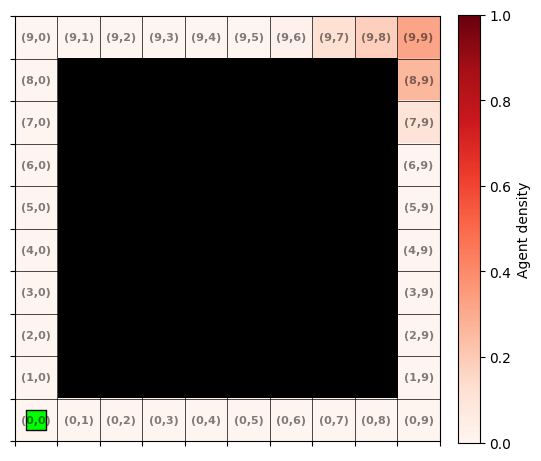

In [8]:
env.reset()
env.rollout(4)
env.render()
env.close()

The issue with manually stepping is that we need to pass the result of `env_td = env.step(action)` through one more filtering step. it's a tensordict, but the next observation is "hidden" inside the `next` key.

Testing the difference between 
- old eval (pass `env_td` straight into next policy) --> wrong
- `env_td = env_td.get('next')` --> correct
- `env_td = env.step_mdp(env_td)` --> correct, would use this for safety

In [9]:
env_td_0 = env.reset()
action_td_0 = policy(env_td_0)
env_td_1 = env.step(action_td_0)
action_td_1_nothing = policy(env_td_1)
print(f"nothing: ag0, logits: {action_td_1_nothing.get(('movement_agent', 'logits'))[0]}")
env_td_1_filtered = env_td_1.get('next')
action_td_1_filtered = policy(env_td_1_filtered)
print(f"filtered: ag0, logits: {action_td_1_filtered.get(('movement_agent', 'logits'))[0]}")
env_td_1_stepmdp = env.step_mdp(env_td_1)  # use this
action_td_1_stepmdp = policy(env_td_1_stepmdp)
print(f"stepmdp: ag0, logits: {action_td_1_stepmdp.get(('movement_agent', 'logits'))[0]}")


nothing: ag0, logits: tensor([ 6.0207, -7.1949, -1.2912, -6.6100,  9.0551],
       grad_fn=<SelectBackward0>)
filtered: ag0, logits: tensor([-2.7981, -7.4861, -3.0005,  0.2866,  7.8913],
       grad_fn=<SelectBackward0>)
stepmdp: ag0, logits: tensor([-2.7981, -7.4861, -3.0005,  0.2866,  7.8913],
       grad_fn=<SelectBackward0>)


Correct manual rollout func looks like this:

In [10]:
def manual_rollout(env, policy, num_steps):
    obs = env.reset()
    for _ in range(num_steps):
        action = policy(obs)
        obs = env.step(action)
        obs = env.step_mdp(obs) 

    return obs


position of ag0: tensor([9., 5.])
logits of ag0: tensor([-11.4166, -14.5079,   2.4558,   6.0619,   4.0410],
       grad_fn=<SelectBackward0>)


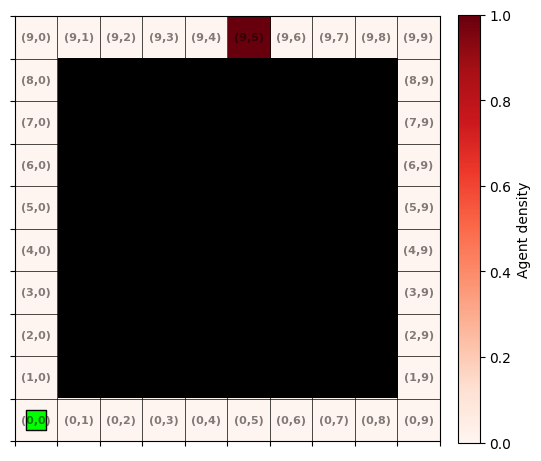

In [11]:
T=10
env.reset()
obs_T = manual_rollout(env, policy, T)
# print logits:
action_T = policy(obs_T)
print(f"position of ag0: {obs_T.get(('movement_agent', 'observation'))[0][:2]*10}")
print(f"logits of ag0: {action_T.get(('movement_agent', 'logits'))[0]}")
env.render()
env.close()

Manually stepping (execute 2nd cell a few times)

In [12]:
obs = env.reset()

position of ag0: tensor([9., 9.])
logits of ag0: tensor([ 6.0207, -7.1949, -1.2912, -6.6100,  9.0551],
       grad_fn=<SelectBackward0>)


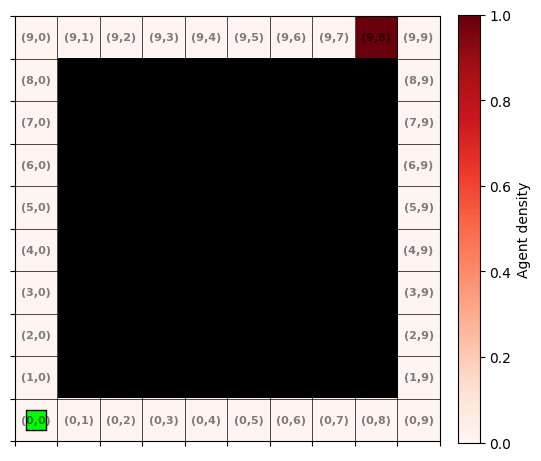

In [13]:
action = policy(obs)
print(f"position of ag0: {obs.get(('movement_agent', 'observation'))[0][:2]*10}")
print(f"logits of ag0: {action.get(('movement_agent', 'logits'))[0]}")
obs = env.step(action)
obs = env.step_mdp(obs)
env.render()
env.close()

## Idea for reward shaping: distance to target
### No. 1: L1 distance (ignores obstacles)
just `-np.abs(x-target[0])-np.abs(y-target[1])`

### No. 2: respect obstacles but ignore congestion
Use BFS. Calc this once at the start of the training run as obstacles are constant.

In [14]:

from collections import deque
def compute_dist_to_goal_map(grid_size, target, obstacles):
    """
    args: grid_size (height, width), target: (x,y), obstacles: list of (x,y)
    """
    height, width = grid_size
    dist_map = np.full((height, width), -1, dtype=np.int32)  # init map with -1 (unvisited)
    obstacle_set = set(obstacles)  # for efficiency O(1) lookups
    queue = deque([(target[0], target[1], 0)])  # BFS queue: (x, y, dist)
    dist_map[target[0], target[1]] = 0  # mark target as dist=0
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
    while queue:
        x, y, dist = queue.popleft()
        if (x, y) in obstacle_set:
            continue
        for dx, dy in directions:
            nx, ny = x + dx, y + dy
            # check out of bounds and unvisited
            if 0 <= nx < height and 0 <= ny < width and dist_map[nx, ny] == -1:
                dist_map[nx, ny] = dist + 1
                queue.append((nx, ny, dist + 1))
    return dist_map





and in `env.step()`:

In [15]:
x, y = new_positions[agent_idx]
dist_to_goal = self.dist_map[x, y]
...
rewards[agent] = target_bonus + dist_to_goal - (...)

NameError: name 'new_positions' is not defined

### No. 2: work congestion into distance 
this is computationally much costlier b/c now 
- distance calc is on a weighted graph, so must change BFS to (costlier) Dijkstra 
- weights change after every agent action (as congestion shifts), so need to recalc a distance map at start of every env step

Dijkstra would look like this:

In [ ]:
import heapq

def comp_congested_dist_map(grid_size, target, obstacles, mean_field, congestion_weight, base_cost):
    """multi-source dijkstra with edge weights = base_cost + congestion_weight * mean_field[destination_cell]"""
    height, width = grid_size
    dist_map = np.full((height, width), np.inf)
    obstacle_set = set(obstacles)  # again for perf, O(1) lookups
    # we use a priority queue by distance (smallest first). initialize:
    heap = [(0.0), target[0], target[1]]
    dist_map[target[0], target[1]] = 0.0
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right as before
    visited = np.zeros((height, width), dtype=np.bool)  # could use dist_map < inf to check as well

    while heap:
        dist, x, y = heapq.heappop(heap)

        if visited[x, y]: 
            continue  # necessary for correctness
        visited[x, y] = True

        for dx, dy in directions:
            nx, ny = x + dx, y + dy

            # skip visited - optional for correctness but faster, b/c dijkstra's prio queue guarantees that won't find shorter path to closed nodes
            if visited[nx, ny]:
                continue 

            # skip out of bounds & obstacles
            if 0 <= nx < height and 0 <= ny < width and not visited[nx, ny] and (nx, ny) not in obstacle_set:
                congestion = mean_field[nx, ny]
                edge_weight = base_cost + congestion_weight * congestion
                new_dist = dist + edge_weight  # new distance to neighbor via current node
                if new_dist < dist_map[nx, ny]:  # if we found shorter path, update and push to prio queue
                    dist_map[nx, ny] = new_dist
                    heapq.heappush(heap, (new_dist, nx, ny))

    dist_map[dist_map == np.inf] = -1  # set unreachable cells to -1
    return dist_map


and then in env_step, you could either delete the old congestion cost or keep both